# Testing `redcal` and `abscal`

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import scipy
import matplotlib.pyplot as plt
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
import linsolve
from copy import deepcopy
import hera_sim
import os
from hera_cal.utils import split_pol, split_bl
%matplotlib inline

In [2]:
from pyuvdata.version import construct_version_info
print('pyuvdata:\n', construct_version_info())
from hera_cal.version import construct_version_info
print('\nhera_cal:\n', construct_version_info())
from linsolve.version import construct_version_info
print('\nlinsolve:\n', construct_version_info())
from hera_sim.version import construct_version_info
print('\nhera_sim:\n', construct_version_info())

pyuvdata:
 {'git_description': 'v1.3-373-g7755782', 'version': '1.3.6', 'git_branch': 'master', 'git_origin': 'https://github.com/HERA-Team/pyuvdata.git', 'git_hash': '775578295187fa6e09a0da6229e6f322d62ebd37'}

hera_cal:
 {'git_description': 'v2.0-661-gea19960', 'version': '2.0', 'git_branch': 'HEAD', 'git_origin': 'git@github.com:HERA-Team/hera_cal.git', 'git_hash': 'ea199607ed73ddfbfcd2d0a2decc49260283da7c'}

linsolve:
 {'git_hash': '4786f0355c7d22947322ac3e2de49f462c40fd11', 'version': '0.0.1', 'git_description': 'v0.0.1-6-g4786f03', 'git_branch': 'master', 'git_origin': 'https://github.com/HERA-Team/linsolve.git'}

hera_sim:
 {'git_hash': 'ce77c5a8aa73947bad6a9552725e3e6bbff1254d', 'version': '0.0.1', 'git_description': 'ce77c5a', 'git_branch': 'master', 'git_origin': 'git@github.com:HERA-Team/hera_sim.git'}


# Generate Uncalibrated Data

In [3]:
testfile = 'randsrc_airybeam_Nsrc100_fullband.uvh5'
if not os.path.exists(testfile):
    path = '/lustre/aoc/projects/hera/alanman/pyuvsim_hera37_fullband_reds'
    os.system('cp ' + os.path.join(path, testfile) + ' ./' + testfile)

In [4]:
hd = io.HERAData(testfile)
data, flags, nsamples = hd.read()

In [5]:
np.random.seed(21)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

# generate gains with a realistic bandpass and delays between -20 and 20 ns
true_gains = hera_sim.sigchain.gen_gains(hd.freqs/1e9, ants, dly_rng=(-20, 20))

# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in true_gains.keys()}

# uncalibratate data and save
true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
              for ant, g in true_gains.items()}
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')
hd.update(data=data)
hd.write_uvh5('uncalibrated_' + testfile, clobber=True)

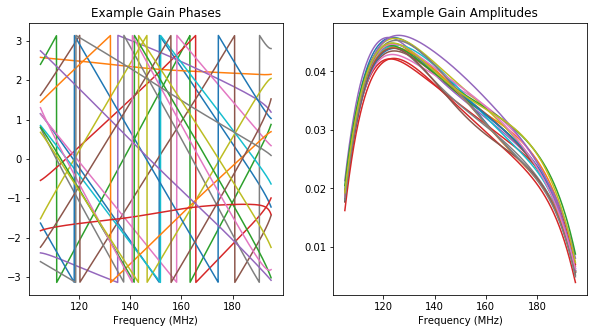

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
for ant in ants[::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6, np.angle(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[0].set_title('Example Gain Phases')
    ax[0].set_xlabel('Frequency (MHz)')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[1].set_title('Example Gain Amplitudes')
    ax[1].set_xlabel('Frequency (MHz)')
    

# Run Redcal

This flags the top and bottom 50 channels. `solar_horizon=90` ensures that no integrations are flagged because the sun is up.

In [7]:
redcal.redcal_run('uncalibrated_' + testfile, 
                  flag_nchan_high=50, flag_nchan_low=50,
                  solar_horizon=90, clobber=True, verbose=True);


Now running redundant calibration without antennas [] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...
Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...

Now saving firstcal gains to uncalibrated_randsrc_airybeam_Nsrc100_fullband.first.calfits
Now saving omnical gains to uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni.calfits
Now saving omnical visibilities to uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni_vis.uvh5


# Run Abscal

Run Abscal on the uncalibrated data, using the `.omni.calfits` calibration from Redcal and the original simulated data as the externally calibrated model.

In [8]:
abscal.post_redcal_abscal_run('uncalibrated_' + testfile,
                              'uncalibrated_' + testfile.replace('.uvh5', '.omni.calfits'),
                              [testfile], clobber=True, verbose=True);



Now calibrating xx-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...finding global phase slopes using the DFT method


invalid value encountered in true_divide


...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.011669548794138668
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1644006491919349e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.14150333288085126
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.93518740295564e-08


invalid value encountered in true_divide
invalid value encountered in true_divide




Now calibrating yy-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...finding global phase slopes using the DFT method
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0453199446643046
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.7366885327745693e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.4624922918699752
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished

# Rephase to Evaluate Solutions

Pick a standard reference antenna (in this case 0) and rephase all gains so that that antennas has 0 phase. This removes the final (albeit unphysical) degree of freedom, allowing the abscal gains and true, simulated gains to be directly compared. 

We expect our answers to match to within single precision, which is how they are stored on disk.

In [9]:
hc = io.HERACal('uncalibrated_randsrc_airybeam_Nsrc100_fullband.abs.calfits')
g, gf, q, tq = hc.read()

In [10]:
refant = {'Jxx': (0, 'Jxx'), 'Jyy': (0, 'Jyy')}
agr = {ant: g[ant] * np.abs(g[refant[ant[1]]]) / g[refant[ant[1]]] 
            for ant in g.keys()}
tgr = {ant: true_gains[ant] * np.abs(true_gains[refant[ant[1]]]) / true_gains[refant[ant[1]]] 
            for ant in true_gains.keys()}

In [11]:
for pol in ['Jxx', 'Jyy']:
    gain_errors = [agr[ant][~gf[ant]] - tgr[ant][~gf[ant]] for ant in tgr if ant[1] == pol]
    assert np.mean(np.abs(gain_errors)) < 1e-6
    print('{} Mean Abs Gain Error: '.format(pol), np.mean(np.abs(gain_errors)))

Jxx Mean Abs Gain Error:  6.708610106320176e-09
Jyy Mean Abs Gain Error:  5.362633052342253e-09


# Cleanup

In [12]:
os.system('rm -rf *' + testfile.replace('.uvh5','*'));